In [22]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [25]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model

# reflect the tables
Base= automap_base()
Base.prepare(engine,reflect=True)

In [27]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [28]:
# Save references to each table
Measurement=Base.classes.measurement
Station = Base.classes.station

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
prev_year_start = dt.datetime(2017,8,1) - dt.timedelta(days=365)
prev_year_end = dt.datetime(2017,8,7) - dt.timedelta(days=365)

tmin,tavg,tmax=calc_temps(prev_year_start.strftime("%Y-%m-%d"),prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin,tavg,tmax)

72.0 77.79545454545455 83.0


C:\Users\pino\.conda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


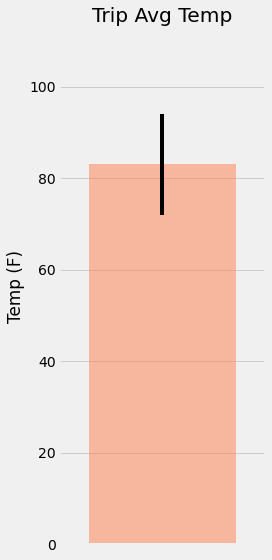

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("images/Avg_Temp.png")
fig.show()

### Daily Rainfall Average

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
total_rainfall_per_station = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= prev_year_start ).\
    filter(Measurement.date <= prev_year_end).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
    
rainfall_df = pd.DataFrame(total_rainfall_per_station, columns=["Station", "Name", "Latitude", "Longitude", "Elevation", "Sum/Total Precipitation"])

rainfall_df


,Station,Name,Latitude,Longitude,Elevation,Sum/Total Precipitation
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.49
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.44
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.24
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.03
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.76
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.49
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.18


In [34]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date, freq='D')

# Strip off the year and save a list of strings in the format %m-%d
trip_month_day = trip_dates.strftime('%m-%d')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0


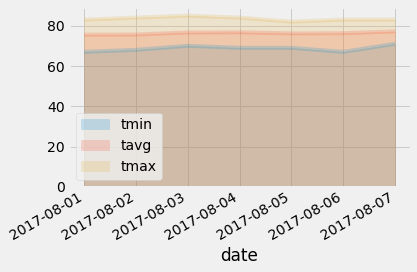

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()

## Close Session

In [38]:
# Close Session
session.close()